# [Class Activation Maps (CAM)]()

### Authors: [Dr. Rahul Remanan](https://linkedin.com/in/rahulremanan)

This is notebook is a modified fork from [here](https://github.com/nickbiso/Keras-Class-Activation-Map).

Class activation maps (CAM) is one of many ways to visualize and get insights from a convolutional neural network (CNN). In this visualization approach, a "Class Activation" heatmap is created over the input image.  A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for every location in any input image, indicating how important each location is with respect to the class considered. It is an easy mechanism to tell an observer which features the CNN model is looking for, while generating the predictions. 

This notebook uses [Keras](https://keras.io) and [Tensorflow](https://tensorflow.org). 

The visual summary of features using CAM is really useful for creating better explainable deep-learning models, and a lot of interesting insights can be derived from a CNN model. Some of these interesting examples are shown towards the end of this notebook.

## Part 1 -- Visualizing the VGG16 model using CAM:

In [1]:
from keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

Using TensorFlow backend.


In [2]:
model_vgg16 = VGG16(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
! wget https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/hummingbird_01.jpg -O hummingbird_01.jpg

--2019-02-21 09:28:41--  https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/hummingbird_01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89448 (87K) [image/jpeg]
Saving to: ‘hummingbird_01.jpg’

hummingbird_01.jpg  100%[===================>]  87.35K  --.-KB/s    in 0.01s   

2019-02-21 09:28:41 (7.92 MB/s) - ‘hummingbird_01.jpg’ saved [89448/89448]



### Sample Image

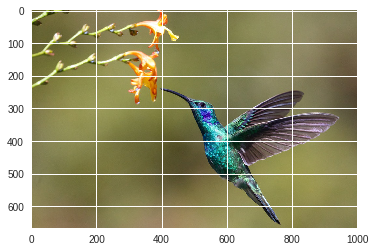

In [4]:
img_path = './hummingbird_01.jpg'
img=mpimg.imread(img_path)
plt.imshow(img)

### Resizing image to fit the input size of VGG

In [0]:
from keras.preprocessing import image
img = image.load_img(img_path, target_size=(224, 224))

### Convert to numpy array

In [0]:
x = image.img_to_array(img)

### Reshape data so that it is in "batch" form because the model only accepts input in this form

In [0]:
import numpy as np
x = np.expand_dims(x, axis=0)

### "Batch" form

In [8]:
x.shape

(1, 224, 224, 3)

### Preprocessing

In [0]:
from keras.applications.vgg16 import preprocess_input
x = preprocess_input(x)

### Prediction

In [10]:
import pandas as pd
from keras.applications.vgg16 import decode_predictions
preds = model_vgg16.predict(x)
predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
print('PREDICTION:',predictions.loc[0,'category'])

PREDICTION: hummingbird


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Top 3 Predictions:')

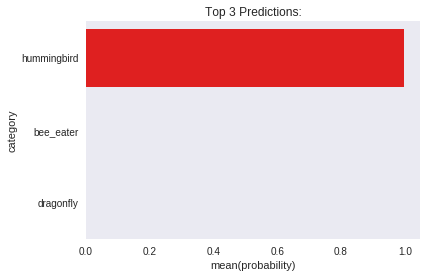

In [11]:
import seaborn as sns
f = sns.barplot(x='probability',y='category',data=predictions,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

### Index of the prediction

In [0]:
argmax = np.argmax(preds[0])

### Get the index of the prediction

In [0]:
output = model_vgg16.output[:, argmax]

### Model Archtecture

In [14]:
model_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### We want to get the final Convolutional Layer

In [0]:
last_conv_layer = model_vgg16.get_layer('block5_conv3')

### Get the Gradient

In [0]:
grads = K.gradients(output, last_conv_layer.output)[0]

### Each entry of this tensor is the mean intensity of the gradient over a specific feature map channel. This has a shape of (512,)

In [0]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

### Access the values of the quantities we just defined

In [0]:
iterate = K.function([model_vgg16.input], [pooled_grads, last_conv_layer.output[0]])

### These are the values of these two quantities, as Numpy arrays, given our sample image of two elephants

In [0]:
pooled_grads_value, conv_layer_output_value = iterate([x])

### We multiply each channel in the feature map array by "how important this channel is" with regard to the prediction class

In [0]:
for i in range(conv_layer_output_value.shape[2]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

### Plotting the Heatmap

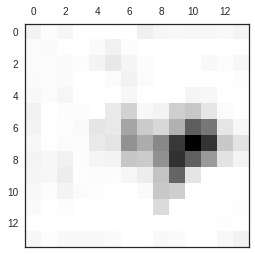

In [21]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

### Load Image with CV2

In [0]:
import cv2
img = cv2.imread(img_path)

### Resize the heatmap

In [0]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

### Convert heatmap to RGB

In [0]:
heatmap = np.uint8(255 * heatmap)

### Apply heatmap to original Image

In [0]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

### Apply heatmap intensity factor

In [0]:
hif = .8

In [0]:
superimposed_img = heatmap * hif + img

### Save to disk

In [0]:
output = './output.jpeg'
cv2.imwrite(output, superimposed_img)

img=mpimg.imread(output)

In [0]:
from google.colab import files
files.download(output)

### Plot

Text(0.5, 1.0, 'hummingbird')

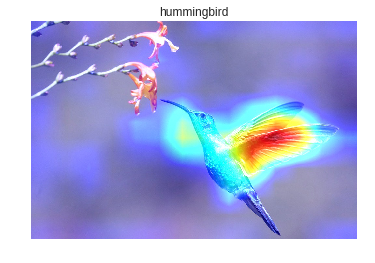

In [30]:
plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0,'category'])

## Part 2 -- Implementing the CAM visualization as a function:

In [0]:
def class_activation_map(INPUT_IMG_FILE=None,
                         PRE_PROCESSOR=None,
                         LABEL_DECODER=None,
                         MODEL=None,
                         LABELS=None,
                         IM_WIDTH=299,
                         IM_HEIGHT=299,
                         CONV_LAYER='conv_7b',
                         URL_MODE=False,
                         FILE_MODE=True,
                         EVAL_STEPS=10,
                         HEATMAP_SHAPE=[14,14]):
  if INPUT_IMG_FILE == None:
    print ('No input file specified to generate predictions ...')
    return
  
  if URL_MODE:
    response = requests.get(INPUT_IMG_FILE)
    img = Image.open(BytesIO(response.content))
    img = img.resize((IM_WIDTH, IM_HEIGHT))
  elif FILE_MODE:
    img = INPUT_IMG_FILE
  else:
    img = image.load_img(INPUT_IMG_FILE, target_size=(IM_WIDTH, IM_HEIGHT))
    
  x = img
  
  if not FILE_MODE:
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if PRE_PROCESSOR !=None:
      preprocess_input = PRE_PROCESSOR
      x = preprocess_input(x)
  
  model = MODEL
  if model == None:
    print ('No input model specified to generate predictions ...')
    return
  labels = LABELS
  
  heatmaps = []
  heatmap_sum = np.empty(HEATMAP_SHAPE, float)
  
  last_conv_layer = model.get_layer(CONV_LAYER)  
  feature_size = tensor_featureSizeExtractor(last_conv_layer)
  
  for step in (range(EVAL_STEPS)):
    start = time.time()
    
    preds = model.predict(x)  
  
    probability = preds.flatten()
    
    prediction = []
    
    if labels !=None:
      prediction = labels[np.argmax(probability)]
    elif LABEL_DECODER !=None:
      prediction = pd.DataFrame(LABEL_DECODER(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
      print('PREDICTION:',prediction.loc[0,'category'])
    else:
      print ('No labels will be generated ...')
      
    accuracy = probability[np.argmax(probability)]
  
    argmax = np.argmax(preds[0])
  
    output = model.output[:, argmax]
  
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    for i in range(feature_size):
      conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    try:
      heatmap_sum = np.add(heatmap_sum, 
                           heatmap)
      heatmaps.append(heatmap)
      if EVAL_STEPS >1:
        del (heatmap)
    except:
      print ('Failed updating heatmaps')
    
    end = time.time()
    execution_time = end - start
    
    print ('Completed processing {} out of {} steps in {} seconds ...'.format(int(step+1), int(EVAL_STEPS), float(execution_time)))
    
  if EVAL_STEPS >1:
    mean_heatmap = heatmap_sum/EVAL_STEPS
  else:
    mean_heatmap = heatmap
  
  return [mean_heatmap, heatmaps, preds[0], prediction, accuracy, probability]

In [0]:
def tensor_featureSizeExtractor(last_conv_layer):
  if len(last_conv_layer.output.get_shape().as_list()) == 4:
    feature_size = last_conv_layer.output.get_shape().as_list()[3]
    return feature_size
  else:
    return 'Received tensor shape: {} instead of expected shape: 4'.format(len(last_conv_layer.output.get_shape().as_list()))

In [0]:
INPUT_IMG_FILE = 'https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/hummingbird_01.jpg'
CONV_LAYER = 'block5_conv3'

In [0]:
from keras.applications.vgg16 import preprocess_input as PRE_PROCESSOR
import requests 
from PIL import Image
from io import BytesIO
import time

In [35]:
output = class_activation_map(INPUT_IMG_FILE,
                              PRE_PROCESSOR=PRE_PROCESSOR,
                              MODEL=model_vgg16,
                              LABELS=None,
                              IM_WIDTH=224,
                              IM_HEIGHT=224,
                              CONV_LAYER=CONV_LAYER,
                              EVAL_STEPS=1,
                              URL_MODE=True,
                              FILE_MODE=False)

No labels will be generated ...
Completed processing 1 out of 1 steps in 0.15799641609191895 seconds ...


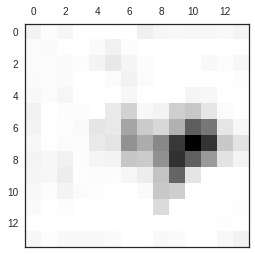

In [36]:
HEATMAP = output[0]

plt.matshow(HEATMAP)
plt.show()

In [0]:
def heatmap_overlay(INPUT_IMG_FILE,
                    HEATMAP,
                    THRESHOLD=0.8):
  img = cv2.imread(INPUT_IMG_FILE)
  
  heatmap = cv2.resize(HEATMAP, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  hif = THRESHOLD
  superimposed_img = heatmap * hif + img
  return [superimposed_img, heatmap]

In [0]:
INPUT_IMG_FILE = './hummingbird_01.jpg'

In [0]:
heatmap_output = heatmap_overlay(INPUT_IMG_FILE,
                                 HEATMAP,
                                 THRESHOLD=0.8)
superimposed_img = heatmap_output[0]

In [0]:
output_file = './class_activation_map.jpeg'
cv2.imwrite(output_file, superimposed_img)

img=mpimg.imread(output_file)

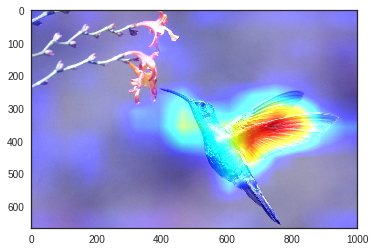

In [41]:
plt.imshow(img)

## Part 3 -- Extend the CAM visualization for Inception-ResNet version 2:

In [0]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

%matplotlib inline
K.clear_session()

In [0]:
model_InceptionResNetV2 = InceptionResNetV2(weights='imagenet')

### Generating Inception-ResNet version 2 summary

In [44]:
model_InceptionResNetV2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Generating visual summary of InceptionResNet version 2

In [45]:
! apt-get install -y graphviz libgraphviz-dev && pip3 install pydot graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
from keras.utils import plot_model 
import pydot 
import graphviz # apt-get install -y graphviz libgraphviz-dev && pip3 install pydot graphviz 
from IPython.display import SVG 
from keras.utils.vis_utils import model_to_dot

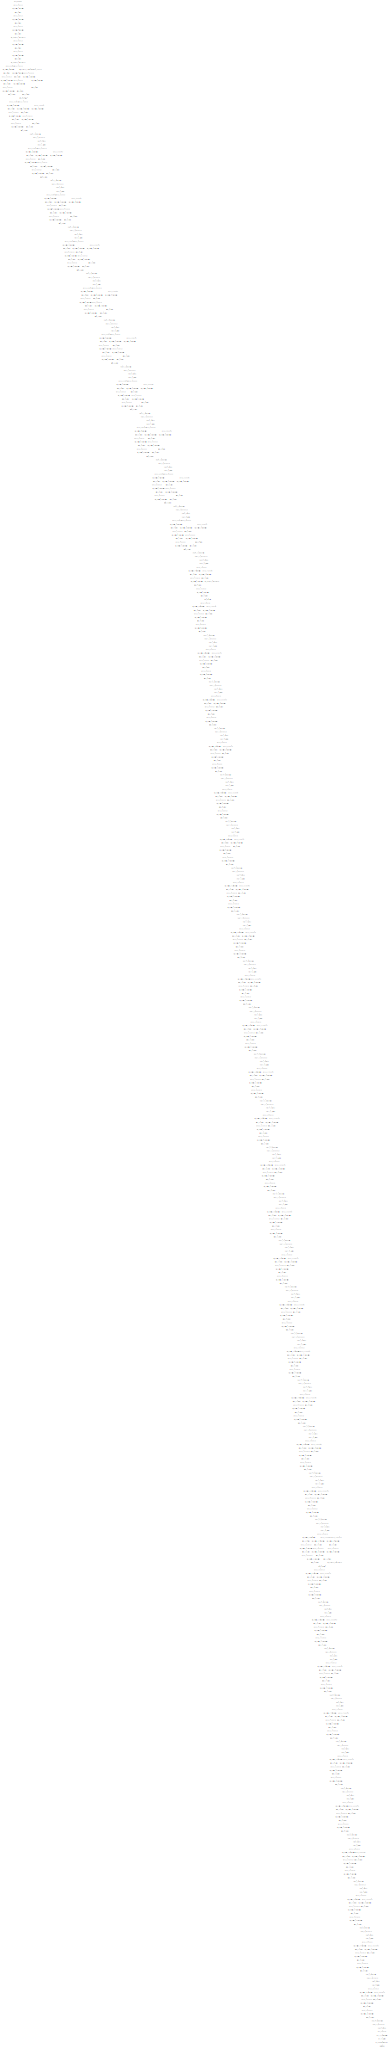

In [47]:
output_dir = './'
plot_model(model_InceptionResNetV2, to_file= output_dir + '/model_summary_plot.png') 
SVG(model_to_dot(model_InceptionResNetV2).create(prog='dot', format='svg'))

In [0]:
img = image.load_img(img_path, target_size=(299, 299))

In [0]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [0]:
from keras.applications.inception_resnet_v2 import preprocess_input as PRE_PROCESSOR
import pandas as pd
from keras.applications.inception_resnet_v2 import decode_predictions as LABEL_DECODER

In [51]:
output = class_activation_map(INPUT_IMG_FILE,
                              PRE_PROCESSOR=PRE_PROCESSOR,
                              LABEL_DECODER=LABEL_DECODER,
                              MODEL=model_InceptionResNetV2,
                              LABELS=None,
                              IM_WIDTH=299,
                              IM_HEIGHT=299,
                              EVAL_STEPS=1,
                              URL_MODE=False,
                              FILE_MODE=False,
                              HEATMAP_SHAPE=[8,8])

PREDICTION: hummingbird
Instructions for updating:
Use tf.cast instead.
Completed processing 1 out of 1 steps in 9.6144540309906 seconds ...


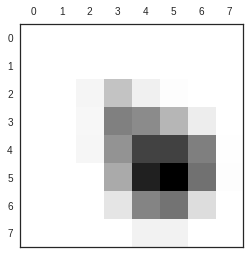

      category  probability
0  hummingbird     0.973336
1  water_ouzel     0.000573
2      jacamar     0.000501


In [52]:
HEATMAP = output[0]
LABEL = output[3]

plt.matshow(HEATMAP)
plt.show()
print (LABEL)

In [0]:
heatmap_output = heatmap_overlay(INPUT_IMG_FILE,
                                 HEATMAP,
                                 THRESHOLD=0.8)
superimposed_img = heatmap_output[0]

In [0]:
output_file = './class_activation_map_InceptionResNetV2.jpeg'
cv2.imwrite(output_file, superimposed_img)

img=mpimg.imread(output_file)

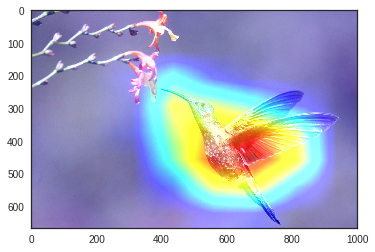

In [55]:
plt.imshow(img)

## Part 4 -- Experimenting with other images

### Test 1 -- Banana

In [59]:
! wget https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/banana_01.jpg -O banana_01.jpg

--2019-02-21 09:30:51--  https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/banana_01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80697 (79K) [image/jpeg]
Saving to: ‘banana_01.jpg’

banana_01.jpg       100%[===================>]  78.81K  --.-KB/s    in 0.01s   

2019-02-21 09:30:51 (7.33 MB/s) - ‘banana_01.jpg’ saved [80697/80697]



In [0]:
INPUT_IMG_FILE = './banana_01.jpg'

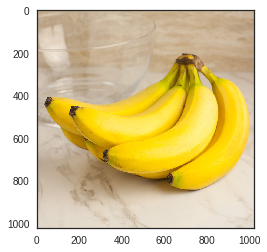

In [61]:
img=mpimg.imread(INPUT_IMG_FILE)
plt.imshow(img)

In [62]:
output = class_activation_map(INPUT_IMG_FILE,
                              PRE_PROCESSOR=PRE_PROCESSOR,
                              LABEL_DECODER=LABEL_DECODER,
                              MODEL=model_InceptionResNetV2,
                              LABELS=None,
                              IM_WIDTH=299,
                              IM_HEIGHT=299,
                              EVAL_STEPS=1,
                              URL_MODE=False,
                              FILE_MODE=False,
                              HEATMAP_SHAPE=[8,8])

PREDICTION: banana
Completed processing 1 out of 1 steps in 4.7812793254852295 seconds ...


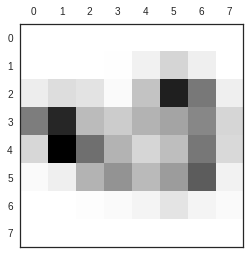

        category  probability
0         banana     0.868550
1         orange     0.006009
2  grocery_store     0.001587


In [63]:
HEATMAP = output[0]
LABEL = output[3]

plt.matshow(HEATMAP)
plt.show()
print (LABEL)

In [0]:
heatmap_output = heatmap_overlay(INPUT_IMG_FILE,
                                 HEATMAP,
                                 THRESHOLD=0.8)
superimposed_img = heatmap_output[0]

In [0]:
output_file = './class_activation_map_InceptionResNetV2.jpeg'
cv2.imwrite(output_file, superimposed_img)

img=mpimg.imread(output_file)

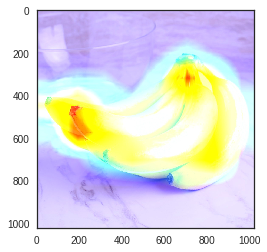

In [66]:
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Top 3 Predictions:')

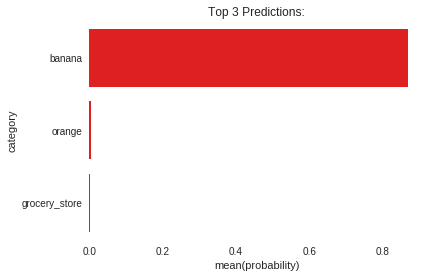

In [67]:
import seaborn as sns
f = sns.barplot(x='probability',y='category',data=LABEL,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

### Test 2 -- Banjo player

In [68]:
! wget https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/banjo_player_01.jpg -O banjo_player_01.jpg

--2019-02-21 09:31:30--  https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/banjo_player_01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7797 (7.6K) [image/jpeg]
Saving to: ‘banjo_player_01.jpg’

banjo_player_01.jpg 100%[===================>]   7.61K  --.-KB/s    in 0s      

2019-02-21 09:31:30 (79.7 MB/s) - ‘banjo_player_01.jpg’ saved [7797/7797]



In [0]:
INPUT_IMG_FILE = './banjo_player_01.jpg'

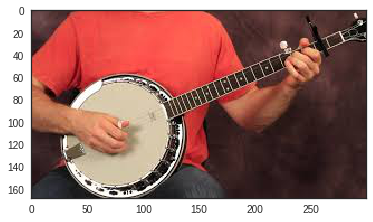

In [70]:
img=mpimg.imread(INPUT_IMG_FILE)
plt.imshow(img)

In [71]:
output = class_activation_map(INPUT_IMG_FILE,
                              PRE_PROCESSOR=PRE_PROCESSOR,
                              LABEL_DECODER=LABEL_DECODER,
                              MODEL=model_InceptionResNetV2,
                              LABELS=None,
                              IM_WIDTH=299,
                              IM_HEIGHT=299,
                              EVAL_STEPS=1,
                              URL_MODE=False,
                              FILE_MODE=False,
                              HEATMAP_SHAPE=[8,8])

PREDICTION: banjo
Completed processing 1 out of 1 steps in 4.5725181102752686 seconds ...


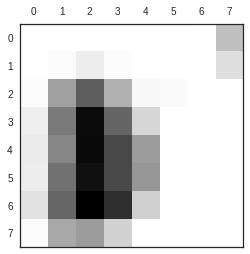

      category  probability
0        banjo     0.933209
1  toilet_seat     0.000398
2         drum     0.000398


In [72]:
HEATMAP = output[0]
LABEL = output[3]

plt.matshow(HEATMAP)
plt.show()
print (LABEL)

In [0]:
heatmap_output = heatmap_overlay(INPUT_IMG_FILE,
                                 HEATMAP,
                                 THRESHOLD=0.8)
superimposed_img = heatmap_output[0]

In [0]:
output_file = './class_activation_map_InceptionResNetV2.jpeg'
cv2.imwrite(output_file, superimposed_img)

img=mpimg.imread(output_file)

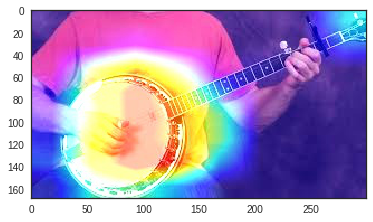

In [75]:
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Top 3 Predictions:')

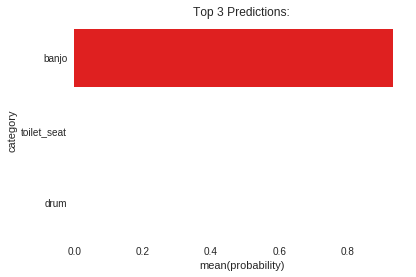

In [76]:
import seaborn as sns
f = sns.barplot(x='probability',y='category',data=LABEL,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

### Test 3 -- Yet another banjo player

In [77]:
! wget https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/banjo_player_02.jpg -O banjo_player_02.jpg

--2019-02-21 09:32:04--  https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/banjo_player_02.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073613 (1.0M) [image/jpeg]
Saving to: ‘banjo_player_02.jpg’

banjo_player_02.jpg 100%[===================>]   1.02M  --.-KB/s    in 0.03s   

2019-02-21 09:32:04 (29.8 MB/s) - ‘banjo_player_02.jpg’ saved [1073613/1073613]



In [0]:
INPUT_IMG_FILE = './banjo_player_02.jpg'

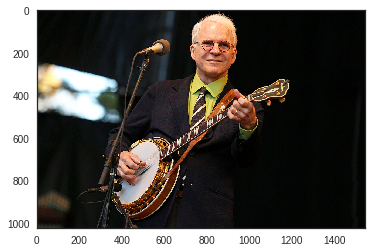

In [79]:
img=mpimg.imread(INPUT_IMG_FILE)
plt.imshow(img)

In [80]:
output = class_activation_map(INPUT_IMG_FILE,
                              PRE_PROCESSOR=PRE_PROCESSOR,
                              LABEL_DECODER=LABEL_DECODER,
                              MODEL=model_InceptionResNetV2,
                              LABELS=None,
                              IM_WIDTH=299,
                              IM_HEIGHT=299,
                              EVAL_STEPS=1,
                              URL_MODE=False,
                              FILE_MODE=False,
                              HEATMAP_SHAPE=[8,8])

PREDICTION: banjo
Completed processing 1 out of 1 steps in 4.621196985244751 seconds ...


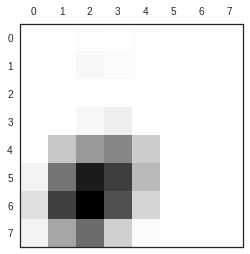

      category  probability
0        banjo     0.956864
1  toilet_seat     0.000349
2     strainer     0.000300


In [81]:
HEATMAP = output[0]
LABEL = output[3]

plt.matshow(HEATMAP)
plt.show()
print (LABEL)

In [0]:
heatmap_output = heatmap_overlay(INPUT_IMG_FILE,
                                 HEATMAP,
                                 THRESHOLD=0.8)
superimposed_img = heatmap_output[0]

In [0]:
output_file = './class_activation_map_InceptionResNetV2.jpeg'
cv2.imwrite(output_file, superimposed_img)

img=mpimg.imread(output_file)

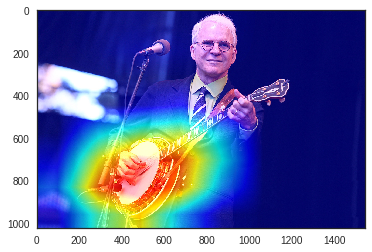

In [84]:
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Top 3 Predictions:')

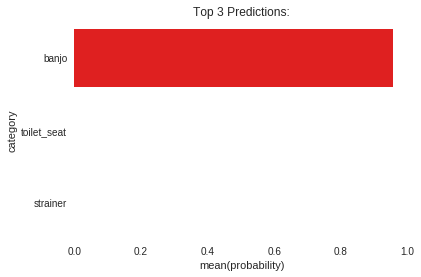

In [85]:
import seaborn as sns
f = sns.barplot(x='probability',y='category',data=LABEL,color="red")
sns.set_style(style='white')
f.grid(False)
f.spines["top"].set_visible(False)
f.spines["right"].set_visible(False)
f.spines["bottom"].set_visible(False)
f.spines["left"].set_visible(False)
f.set_title('Top 3 Predictions:')

### Test 4 -- Throne

In [86]:
! wget https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/throne_01.jpg -O throne_01.jpg

--2019-02-21 09:32:38--  https://raw.githubusercontent.com/rahulremanan/python_tutorial/master/Machine_Vision/02_Object_Prediction/test_images/throne_01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 768540 (751K) [image/jpeg]
Saving to: ‘throne_01.jpg’

throne_01.jpg       100%[===================>] 750.53K  --.-KB/s    in 0.03s   

2019-02-21 09:32:38 (26.0 MB/s) - ‘throne_01.jpg’ saved [768540/768540]



In [0]:
INPUT_IMG_FILE = './throne_01.jpg'

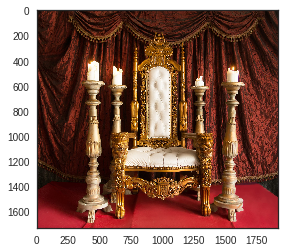

In [88]:
img=mpimg.imread(INPUT_IMG_FILE)
plt.imshow(img)

In [89]:
output = class_activation_map(INPUT_IMG_FILE,
                              PRE_PROCESSOR=PRE_PROCESSOR,
                              LABEL_DECODER=LABEL_DECODER,
                              MODEL=model_InceptionResNetV2,
                              LABELS=None,
                              IM_WIDTH=299,
                              IM_HEIGHT=299,
                              EVAL_STEPS=1,
                              URL_MODE=False,
                              FILE_MODE=False,
                              HEATMAP_SHAPE=[8,8])

PREDICTION: throne
Completed processing 1 out of 1 steps in 4.443957090377808 seconds ...


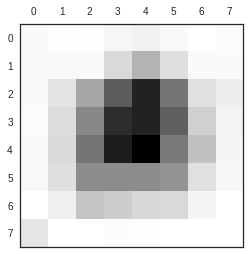

      category  probability
0       throne     0.901864
1  four-poster     0.014415
2        altar     0.002789


In [90]:
HEATMAP = output[0]
LABEL = output[3]

plt.matshow(HEATMAP)
plt.show()
print (LABEL)

In [0]:
heatmap_output = heatmap_overlay(INPUT_IMG_FILE,
                                 HEATMAP,
                                 THRESHOLD=0.8)
superimposed_img = heatmap_output[0]

In [0]:
output_file = './class_activation_map_InceptionResNetV2.jpeg'
cv2.imwrite(output_file, superimposed_img)

img=mpimg.imread(output_file)

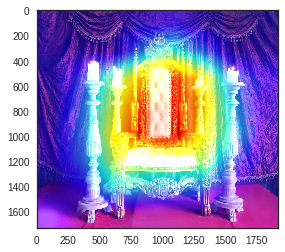

In [93]:
plt.imshow(img)